In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from functools import partial as _partial
from itertools import chain as _chain

import numpy as np
import sklearn

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils import data

import matplotlib.pyplot as plt
import pandas as pd

In [7]:
#Load the data set

# trining dataset 
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform= transforms.ToTensor()
    )

# test dataset
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform= transforms.ToTensor()
    )

In [8]:
# Creat a generic model with 1 hidden layer and n hidden units

class FullyConnected(nn.Module):
    def __init__(self, hidden_dims=128):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(784, hidden_dims, bias=True)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [9]:
# define the hyperparameters
BATCH_SIZE = 512
TEST_BATCH_SIZE = 1024

In [10]:
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [11]:
# construct the dataloader for the traininig dataset.
 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=training_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True)

# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=True)

In [12]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''
    
    running_loss = 0.0
    correct = 0
    model = model.to(device)
    model.train(mode=True)
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
    model.train(mode=False)
    
    return running_loss / len(train_dataloader.dataset)


def fit(
    model : nn.Module,
    train_dataloader: DataLoader,
    optimizer : torch.optim.Optimizer,
    epochs : int,
    device : torch.device):
  losses = []
  
  for epoch in range(epochs):
      
    running_loss = train_epoch(
        model = model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        device = device )
    
    print(f"Epoch {epoch}: Loss={running_loss}")
    losses.append(running_loss)
    
  return losses    

In [28]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')
    return test_loss

In [29]:
hidden_dims = [*range(5,1000,60)]
final_losses = []
models = []

len(hidden_dims)

17

In [30]:
import pandas as pd
import tqdm as tqdm

zero_one_loss = pd.DataFrame(columns=['number_params', 'test_loss', 'train_loss', 'accuracy', 'epochs'])

number_params = []
test_loss = []
train_loss = []
accuracy = []
epochs = 60

for i in tqdm.tqdm(range(len(hidden_dims)), desc= "Testing different models"):
  
  #set the model
  models.append(FullyConnected(hidden_dims[i]))
  #set the optimizer
  models[i] = models[i].to(DEVICE)
  optimizer = optim.SGD(models[i].parameters(), lr=0.005, momentum=0.95)
  # fet the number of parameters weights and biases
  params = sum(p.numel() for p in models[i].parameters() if p.requires_grad)
  
  print("testing Model with ", hidden_dims[i], "hidden weights : ", params, "parameters")
  
  # train the model and get the training loss
  training_loss = fit(
    model=models[i], 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    device=DEVICE)
  
  # get the test loss
  test_losses = predict(models[i], test_dataloader, DEVICE)
  train_loss_after = predict(models[i], train_dataloader, DEVICE)
  
  if train_loss_after == training_loss[-1]:
    print("CORRECT: training loss is the same as the last training loss")
  elif train_loss_after != training_loss[-1]:
    print("INCORRECT: training loss is NOT the same as the last training loss")
    
  # save the results in a dataframe
  zero_one_loss = zero_one_loss.append(
    {'number_params': params, 
     'test_loss': test_losses, 
     'train_loss': train_loss_after, 
     'test_error': 100 - test_losses*100, 
     'train_error': 100 - train_loss_after*100,
     'epochs': epochs}, ignore_index=True)
  
  print("last training loss: ", training_loss[-1])
  print("test loss: ", test_losses)
  print("accuracy: ", 100 - test_losses*100)
  
zero_one_loss.to_csv('zero_one_loss_MLP.csv')
print("DONE!")
  #final_losses.append(training_loss[-1])

Testing different models:   0%|          | 0/17 [00:00<?, ?it/s]

testing Model with  5 hidden weights :  3985 parameters
Epoch 0: Loss=0.0021191962281862896
Epoch 1: Loss=0.0015607568323612213
Epoch 2: Loss=0.0012022824943065643
Epoch 3: Loss=0.0010249797155459722
Epoch 4: Loss=0.0009088436136643091
Epoch 5: Loss=0.0008186090618371964
Epoch 6: Loss=0.0007574730803569158
Epoch 7: Loss=0.0007185685187578202
Epoch 8: Loss=0.0006902303626139959
Epoch 9: Loss=0.0006692755401134491
Epoch 10: Loss=0.0006506457895040513
Epoch 11: Loss=0.0006372441013654073
Epoch 12: Loss=0.0006247075895468394
Epoch 13: Loss=0.0006145583222309748
Epoch 14: Loss=0.000605352505048116
Epoch 15: Loss=0.0005978516419728597
Epoch 16: Loss=0.0005914900183677673
Epoch 17: Loss=0.0005845020373662313
Epoch 18: Loss=0.0005795259942611059
Epoch 19: Loss=0.0005740932966272036
Epoch 20: Loss=0.0005690722097953161
Epoch 21: Loss=0.0005659502218166988
Epoch 22: Loss=0.0005606839487950008
Epoch 23: Loss=0.0005572822908560435
Epoch 24: Loss=0.0005538597772518794
Epoch 25: Loss=0.0005507030884

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:   6%|▌         | 1/17 [03:03<49:03, 183.95s/it]

Test set: Avg. loss: 0.0005, Accuracy: 51125/60000 (85%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.0005014558225870132
test loss:  0.00025533783733844756
accuracy:  99.97446621626615
testing Model with  65 hidden weights :  51685 parameters
Epoch 0: Loss=0.00200051012635231
Epoch 1: Loss=0.0009566936175028483
Epoch 2: Loss=0.0005389883990089099
Epoch 3: Loss=0.00043811235626538595
Epoch 4: Loss=0.00039193714608748756
Epoch 5: Loss=0.0003650708511471748
Epoch 6: Loss=0.00034619565854469934
Epoch 7: Loss=0.000332462706665198
Epoch 8: Loss=0.0003205634146928787
Epoch 9: Loss=0.000310667817791303
Epoch 10: Loss=0.00030216460476318994
Epoch 11: Loss=0.00029444326410690944
Epoch 12: Loss=0.0002872876974443595
Epoch 13: Loss=0.0002810981554289659
Epoch 14: Loss=0.00027441282644867894
Epoch 15: Loss=0.00026830446645617487
Epoch 16: Loss=0.00026309716825683913
Epoch 17: Loss=0.00025790549019972484
Epoch 18: Loss=0.0002529841552178065
Epoch 19: Los

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  12%|█▏        | 2/17 [06:12<46:42, 186.84s/it]

Test set: Avg. loss: 0.0001, Accuracy: 57567/60000 (96%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00014146140627563
test loss:  7.487163543701172e-05
accuracy:  99.9925128364563
testing Model with  125 hidden weights :  99385 parameters
Epoch 0: Loss=0.001979452774922053
Epoch 1: Loss=0.0008941772709290187
Epoch 2: Loss=0.0005091250598430634
Epoch 3: Loss=0.00042067127078771594
Epoch 4: Loss=0.00037986307789882024
Epoch 5: Loss=0.000354864402115345
Epoch 6: Loss=0.0003371818075577418
Epoch 7: Loss=0.0003235471253593763
Epoch 8: Loss=0.00031183793594439824
Epoch 9: Loss=0.00030195944383740425
Epoch 10: Loss=0.00029414394696553547
Epoch 11: Loss=0.00028579466318090756
Epoch 12: Loss=0.0002785291997094949
Epoch 13: Loss=0.0002718582880993684
Epoch 14: Loss=0.0002647675387561321
Epoch 15: Loss=0.00025903891921043396
Epoch 16: Loss=0.0002525836023191611
Epoch 17: Loss=0.0002470543389519056
Epoch 18: Loss=0.00024184503083427746
Epoch 19: Loss=

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  18%|█▊        | 3/17 [09:58<47:45, 204.66s/it]

Test set: Avg. loss: 0.0001, Accuracy: 57950/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00012356021689871946
test loss:  6.6814586520195e-05
accuracy:  99.99331854134797
testing Model with  185 hidden weights :  147085 parameters
Epoch 0: Loss=0.001946245284875234
Epoch 1: Loss=0.0008640264560778936
Epoch 2: Loss=0.0005009712358315786
Epoch 3: Loss=0.0004175178915262222
Epoch 4: Loss=0.00037840670893589655
Epoch 5: Loss=0.0003542846083641052
Epoch 6: Loss=0.0003366395056247711
Epoch 7: Loss=0.0003221565343439579
Epoch 8: Loss=0.00031203435361385346
Epoch 9: Loss=0.00030167447477579115
Epoch 10: Loss=0.00029266782452662784
Epoch 11: Loss=0.0002847891290982564
Epoch 12: Loss=0.0002780350814263026
Epoch 13: Loss=0.0002710322399934133
Epoch 14: Loss=0.00026411403665939966
Epoch 15: Loss=0.00025750626052419343
Epoch 16: Loss=0.0002517170287668705
Epoch 17: Loss=0.000246633718162775
Epoch 18: Loss=0.00024107204874356588
Epoch 19: Los

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  24%|██▎       | 4/17 [13:05<42:50, 197.71s/it]

Test set: Avg. loss: 0.0001, Accuracy: 57983/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011974729746580124
test loss:  6.432972177863121e-05
accuracy:  99.99356702782214
testing Model with  245 hidden weights :  194785 parameters
Epoch 0: Loss=0.0019004662692546845
Epoch 1: Loss=0.000815211433172226
Epoch 2: Loss=0.0004917311847209931
Epoch 3: Loss=0.00041158084869384766
Epoch 4: Loss=0.0003734651307264964
Epoch 5: Loss=0.00035068998634815214
Epoch 6: Loss=0.0003335844854513804
Epoch 7: Loss=0.0003206155861417452
Epoch 8: Loss=0.0003098562056819598
Epoch 9: Loss=0.0003002702370285988
Epoch 10: Loss=0.00029174779231349625
Epoch 11: Loss=0.00028372935925920803
Epoch 12: Loss=0.00027660346378882727
Epoch 13: Loss=0.000270004499455293
Epoch 14: Loss=0.00026303256129225097
Epoch 15: Loss=0.0002571212311585744
Epoch 16: Loss=0.0002513072170317173
Epoch 17: Loss=0.0002456400911013285
Epoch 18: Loss=0.00024019826799631118
Epoch 19: L

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  29%|██▉       | 5/17 [16:13<38:48, 194.03s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58030/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011953767873346806
test loss:  6.483402997255326e-05
accuracy:  99.99351659700274
testing Model with  305 hidden weights :  242485 parameters
Epoch 0: Loss=0.0018960168818632761
Epoch 1: Loss=0.0007999838709831238
Epoch 2: Loss=0.0004861676588654518
Epoch 3: Loss=0.0004090764254331589
Epoch 4: Loss=0.00037243987172842026
Epoch 5: Loss=0.00034975716918706894
Epoch 6: Loss=0.0003327210456132889
Epoch 7: Loss=0.00031904442459344866
Epoch 8: Loss=0.00030786940157413484
Epoch 9: Loss=0.00029809723297754924
Epoch 10: Loss=0.00028966595033804576
Epoch 11: Loss=0.0002810997133453687
Epoch 12: Loss=0.0002735699824988842
Epoch 13: Loss=0.00026678776144981384
Epoch 14: Loss=0.0002599372781813145
Epoch 15: Loss=0.0002533875711262226
Epoch 16: Loss=0.00024764931375781694
Epoch 17: Loss=0.00024163182601332666
Epoch 18: Loss=0.00023580026626586915
Epoch 

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  35%|███▌      | 6/17 [19:24<35:24, 193.15s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58065/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011596058942377568
test loss:  6.350387632846832e-05
accuracy:  99.99364961236715
testing Model with  365 hidden weights :  290185 parameters
Epoch 0: Loss=0.0018914764920870462
Epoch 1: Loss=0.0008034899254639944
Epoch 2: Loss=0.0004916550959149996
Epoch 3: Loss=0.0004112925852338473
Epoch 4: Loss=0.00037381945004065834
Epoch 5: Loss=0.00034944325735171633
Epoch 6: Loss=0.00033223868558804196
Epoch 7: Loss=0.00031833620717128117
Epoch 8: Loss=0.0003066791626314322
Epoch 9: Loss=0.0002970115229487419
Epoch 10: Loss=0.000287637838969628
Epoch 11: Loss=0.0002796081359187762
Epoch 12: Loss=0.0002720204859972
Epoch 13: Loss=0.0002647265707453092
Epoch 14: Loss=0.0002583193801343441
Epoch 15: Loss=0.00025221948698163035
Epoch 16: Loss=0.00024618522798021636
Epoch 17: Loss=0.0002405105469127496
Epoch 18: Loss=0.00023451070909698805
Epoch 19: Los

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  41%|████      | 7/17 [22:39<32:17, 193.70s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58095/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011511442909638087
test loss:  6.220355778932571e-05
accuracy:  99.99377964422106
testing Model with  425 hidden weights :  337885 parameters
Epoch 0: Loss=0.00188895862698555
Epoch 1: Loss=0.0007951792965332667
Epoch 2: Loss=0.00048462830285231275
Epoch 3: Loss=0.00040844106127818424
Epoch 4: Loss=0.00037229265918334325
Epoch 5: Loss=0.0003486698413888613
Epoch 6: Loss=0.00033223126232624053
Epoch 7: Loss=0.00031852052509784697
Epoch 8: Loss=0.00030697865759332974
Epoch 9: Loss=0.0002971451863646507
Epoch 10: Loss=0.00028840005472302436
Epoch 11: Loss=0.0002800188072025776
Epoch 12: Loss=0.00027219755003849664
Epoch 13: Loss=0.0002643760338425636
Epoch 14: Loss=0.00025728029012680054
Epoch 15: Loss=0.0002511366911232471
Epoch 16: Loss=0.0002448685442407926
Epoch 17: Loss=0.00023859712208310763
Epoch 18: Loss=0.00023303964361548425
Epoch 1

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  47%|████▋     | 8/17 [25:55<29:09, 194.36s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58141/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011268739054600398
test loss:  6.138750612735749e-05
accuracy:  99.99386124938727
testing Model with  485 hidden weights :  385585 parameters
Epoch 0: Loss=0.001882281643152237
Epoch 1: Loss=0.0007860028982162475
Epoch 2: Loss=0.0004817945639292399
Epoch 3: Loss=0.00040579522103071215
Epoch 4: Loss=0.0003702763319015503
Epoch 5: Loss=0.0003476287956039111
Epoch 6: Loss=0.00033055543849865596
Epoch 7: Loss=0.00031797434836626054
Epoch 8: Loss=0.0003068374757965406
Epoch 9: Loss=0.0002974709448715051
Epoch 10: Loss=0.0002880087338387966
Epoch 11: Loss=0.0002804883581896623
Epoch 12: Loss=0.00027285903245210646
Epoch 13: Loss=0.0002655229161183039
Epoch 14: Loss=0.00025819631069898605
Epoch 15: Loss=0.00025194878081480663
Epoch 16: Loss=0.00024582641248901683
Epoch 17: Loss=0.00024011066456635792
Epoch 18: Loss=0.00023440048520763715
Epoch 19

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  53%|█████▎    | 9/17 [29:16<26:12, 196.53s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58140/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.0001124036173025767
test loss:  6.135382950305939e-05
accuracy:  99.9938646170497
testing Model with  545 hidden weights :  433285 parameters
Epoch 0: Loss=0.001841705906391144
Epoch 1: Loss=0.0007528329988320669
Epoch 2: Loss=0.0004764715686440468
Epoch 3: Loss=0.00040524577051401136
Epoch 4: Loss=0.0003694840759038925
Epoch 5: Loss=0.000347177151342233
Epoch 6: Loss=0.00033029281000296275
Epoch 7: Loss=0.0003176947092016538
Epoch 8: Loss=0.00030699274788300197
Epoch 9: Loss=0.00029731297840674716
Epoch 10: Loss=0.00028806712081034977
Epoch 11: Loss=0.00028014432489871976
Epoch 12: Loss=0.0002728449575603008
Epoch 13: Loss=0.000265599042425553
Epoch 14: Loss=0.00025887144232789673
Epoch 15: Loss=0.0002523243484397729
Epoch 16: Loss=0.0002466744124889374
Epoch 17: Loss=0.00024059220130244892
Epoch 18: Loss=0.00023457821210225423
Epoch 19: Lo

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  59%|█████▉    | 10/17 [32:38<23:06, 198.07s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58157/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011265835141142209
test loss:  6.098879352211952e-05
accuracy:  99.99390112064779
testing Model with  605 hidden weights :  480985 parameters
Epoch 0: Loss=0.0018493262569109598
Epoch 1: Loss=0.0007625133574008942
Epoch 2: Loss=0.0004776319166024526
Epoch 3: Loss=0.00040375225593646365
Epoch 4: Loss=0.00036771269937356315
Epoch 5: Loss=0.00034483728756507236
Epoch 6: Loss=0.0003289451544483503
Epoch 7: Loss=0.00031625299056371053
Epoch 8: Loss=0.000304833614329497
Epoch 9: Loss=0.0002947516866028309
Epoch 10: Loss=0.00028628614271680513
Epoch 11: Loss=0.0002783978094657262
Epoch 12: Loss=0.00027090354536970455
Epoch 13: Loss=0.0002636764444410801
Epoch 14: Loss=0.0002570154113074144
Epoch 15: Loss=0.0002504832185804844
Epoch 16: Loss=0.000244724099089702
Epoch 17: Loss=0.00023840655634800592
Epoch 18: Loss=0.0002326272832850615
Epoch 19: L

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  65%|██████▍   | 11/17 [36:04<20:03, 200.51s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58188/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011183160183330377
test loss:  6.072084903717041e-05
accuracy:  99.99392791509628
testing Model with  665 hidden weights :  528685 parameters
Epoch 0: Loss=0.0018506247361501059
Epoch 1: Loss=0.0007509618510802586
Epoch 2: Loss=0.00047090146591266
Epoch 3: Loss=0.00040050763090451557
Epoch 4: Loss=0.00036540537178516387
Epoch 5: Loss=0.0003424871325492859
Epoch 6: Loss=0.0003259415954351425
Epoch 7: Loss=0.00031226304868857066
Epoch 8: Loss=0.0003006007601817449
Epoch 9: Loss=0.0002905826392273108
Epoch 10: Loss=0.00028196279952923456
Epoch 11: Loss=0.0002736315896113714
Epoch 12: Loss=0.000266551794608434
Epoch 13: Loss=0.0002584814876317978
Epoch 14: Loss=0.00025203026458621024
Epoch 15: Loss=0.0002454442573090394
Epoch 16: Loss=0.00023989837144811947
Epoch 17: Loss=0.0002337090658644835
Epoch 18: Loss=0.00022844680274526277
Epoch 19: Lo

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  71%|███████   | 12/17 [39:37<17:02, 204.50s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58204/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00011002052314579487
test loss:  5.991016551852226e-05
accuracy:  99.99400898344815
testing Model with  725 hidden weights :  576385 parameters
Epoch 0: Loss=0.001830062222480774
Epoch 1: Loss=0.0007335318262378374
Epoch 2: Loss=0.0004673596744736036
Epoch 3: Loss=0.00039936273644367856
Epoch 4: Loss=0.00036567147572835285
Epoch 5: Loss=0.0003439313272635142
Epoch 6: Loss=0.00032781638850768407
Epoch 7: Loss=0.00031531686931848525
Epoch 8: Loss=0.0003043469170729319
Epoch 9: Loss=0.0002950110686322053
Epoch 10: Loss=0.0002866606247921785
Epoch 11: Loss=0.00027860410511493683
Epoch 12: Loss=0.00027075340400139493
Epoch 13: Loss=0.000263380262007316
Epoch 14: Loss=0.0002568496656914552
Epoch 15: Loss=0.00024984518935283024
Epoch 16: Loss=0.00024379826957980793
Epoch 17: Loss=0.0002379719098409017
Epoch 18: Loss=0.00023174034530917803
Epoch 19:

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  76%|███████▋  | 13/17 [43:06<13:43, 205.81s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58199/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00010983105935156346
test loss:  5.935349985957146e-05
accuracy:  99.99406465001404
testing Model with  785 hidden weights :  624085 parameters
Epoch 0: Loss=0.0018075484156608581
Epoch 1: Loss=0.0007197772115468978
Epoch 2: Loss=0.0004621867785851161
Epoch 3: Loss=0.0003954645037651062
Epoch 4: Loss=0.0003626149083177249
Epoch 5: Loss=0.0003406192163626353
Epoch 6: Loss=0.00032437290151913963
Epoch 7: Loss=0.00031137618720531465
Epoch 8: Loss=0.00029974052061637244
Epoch 9: Loss=0.0002897109131018321
Epoch 10: Loss=0.00028067301536599797
Epoch 11: Loss=0.0002725871632496516
Epoch 12: Loss=0.00026484586149454117
Epoch 13: Loss=0.0002576871524254481
Epoch 14: Loss=0.00025133462076385815
Epoch 15: Loss=0.0002448922373354435
Epoch 16: Loss=0.00023819594954450926
Epoch 17: Loss=0.0002325393577416738
Epoch 18: Loss=0.00022717118163903554
Epoch 19

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  82%|████████▏ | 14/17 [46:40<10:24, 208.21s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58215/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00010878784780701002
test loss:  5.965885072946549e-05
accuracy:  99.99403411492705
testing Model with  845 hidden weights :  671785 parameters
Epoch 0: Loss=0.0018062311510245006
Epoch 1: Loss=0.0007187206322948138
Epoch 2: Loss=0.000464126281440258
Epoch 3: Loss=0.0003971843401590983
Epoch 4: Loss=0.0003632193018992742
Epoch 5: Loss=0.00034104873339335125
Epoch 6: Loss=0.00032476205925146737
Epoch 7: Loss=0.0003115793988108635
Epoch 8: Loss=0.00029998209923505785
Epoch 9: Loss=0.0002901764256258806
Epoch 10: Loss=0.00028170615310470264
Epoch 11: Loss=0.0002738031476736069
Epoch 12: Loss=0.00026570017834504447
Epoch 13: Loss=0.0002585476115345955
Epoch 14: Loss=0.00025164517238736154
Epoch 15: Loss=0.0002455162001152833
Epoch 16: Loss=0.00023941621258854865
Epoch 17: Loss=0.00023351868068178494
Epoch 18: Loss=0.00022798110991716384
Epoch 19

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  88%|████████▊ | 15/17 [50:18<07:02, 211.09s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58252/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00010829102452844381
test loss:  5.908690318465233e-05
accuracy:  99.99409130968154
testing Model with  905 hidden weights :  719485 parameters
Epoch 0: Loss=0.0017927556693553926
Epoch 1: Loss=0.0007106170773506164
Epoch 2: Loss=0.0004627277692159017
Epoch 3: Loss=0.0003961981286605199
Epoch 4: Loss=0.000362949638068676
Epoch 5: Loss=0.0003412241940697034
Epoch 6: Loss=0.00032428031514088315
Epoch 7: Loss=0.00031124671945969266
Epoch 8: Loss=0.00029957106163104374
Epoch 9: Loss=0.00029057313799858096
Epoch 10: Loss=0.0002809468982120355
Epoch 11: Loss=0.00027278699750701586
Epoch 12: Loss=0.00026485750103990235
Epoch 13: Loss=0.00025790637483199435
Epoch 14: Loss=0.00025118117878834405
Epoch 15: Loss=0.00024482473209500315
Epoch 16: Loss=0.00023873283142844835
Epoch 17: Loss=0.00023269687270124754
Epoch 18: Loss=0.0002273047002653281
Epoch 

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models:  94%|█████████▍| 16/17 [53:54<03:32, 212.81s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58225/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.0001082234504322211
test loss:  5.9296289086341856e-05
accuracy:  99.99407037109137
testing Model with  965 hidden weights :  767185 parameters
Epoch 0: Loss=0.0017944591462612151
Epoch 1: Loss=0.0007100196997324626
Epoch 2: Loss=0.000462507064640522
Epoch 3: Loss=0.00039539646903673806
Epoch 4: Loss=0.00036140569349129995
Epoch 5: Loss=0.00033922802557547887
Epoch 6: Loss=0.00032187517980734507
Epoch 7: Loss=0.0003086271236340205
Epoch 8: Loss=0.00029748436013857525
Epoch 9: Loss=0.00028731706539789835
Epoch 10: Loss=0.0002780609781543414
Epoch 11: Loss=0.00026967721581459044
Epoch 12: Loss=0.0002617968981464704
Epoch 13: Loss=0.0002544977438946565
Epoch 14: Loss=0.00024766474291682244
Epoch 15: Loss=0.00024112862745920817
Epoch 16: Loss=0.00023540235385298728
Epoch 17: Loss=0.0002294261582195759
Epoch 18: Loss=0.00022395491451025008
Epoch 

C:\Users\hecma\AppData\Local\Temp\ipykernel_11316\2037172825.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zero_one_loss = zero_one_loss.append(
Testing different models: 100%|██████████| 17/17 [57:37<00:00, 203.38s/it]

Test set: Avg. loss: 0.0001, Accuracy: 58239/60000 (97%)
iNCORRECT: training loss is NOT the same as the last training loss
last training loss:  0.00010783535788456599
test loss:  5.8865516632795334e-05
accuracy:  99.99411344833672
DONE!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


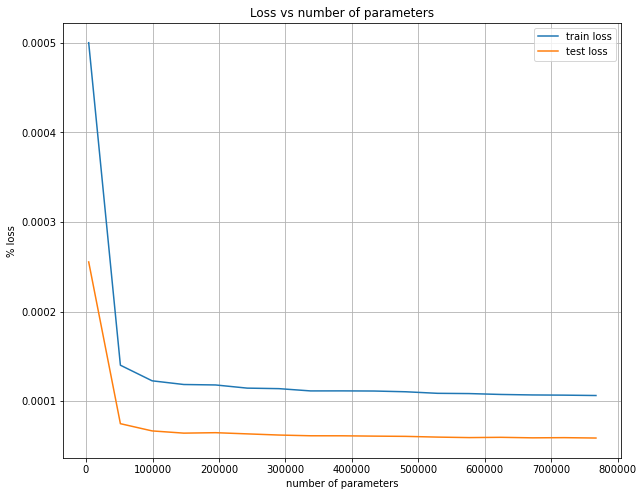

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(zero_one_loss['number_params'], zero_one_loss['train_loss'])
ax.plot(zero_one_loss['number_params'], zero_one_loss['test_loss'])
ax.set_xlabel('number of parameters')
ax.set_ylabel('% loss')
ax.set_title('Loss vs number of parameters')
ax.legend()
ax.grid(True)
plt.legend(['train loss', 'test loss'])

In [32]:
zero_one_loss.head()

,number_params,test_loss,train_loss,accuracy,epochs,test_error,train_error
0,3985.0,0.000255,0.0005,NaN,60.0,99.974466,99.950006
1,51685.0,0.000075,0.00014,NaN,60.0,99.992513,99.985988
2,99385.0,0.000067,0.000123,NaN,60.0,99.993319,99.987729
3,147085.0,0.000064,0.000119,NaN,60.0,99.993567,99.988142
4,194785.0,0.000065,0.000118,NaN,60.0,99.993517,99.988192
